<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:11: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Pratham Kumar\AppData\Local\Temp\ipykernel_48668\2173407998.py:11: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv('D:\gitfolder\Data-DaVinci\Week 4\Assignment\FILES\parkingLot.csv')
C:\Users\Pratham Kumar\AppData\Local\Temp\ipykernel_48668\2173407998.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  entries_per_day_ffill = entries_per_day.fillna(method='ffill')
c:\Users\Pratham Kumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Pratham Kumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, s

ARIMA Scores: {'MASE': np.float64(1.0958765247269449), 'MAPE': np.float64(5.415131406319114)}
ETS Scores: {'MASE': np.float64(1.2541240404541052), 'MAPE': np.float64(6.256658003926942)}
Linear Regression Scores: {'MASE': np.float64(1.199022085024485), 'MAPE': np.float64(5.874314395320469)}


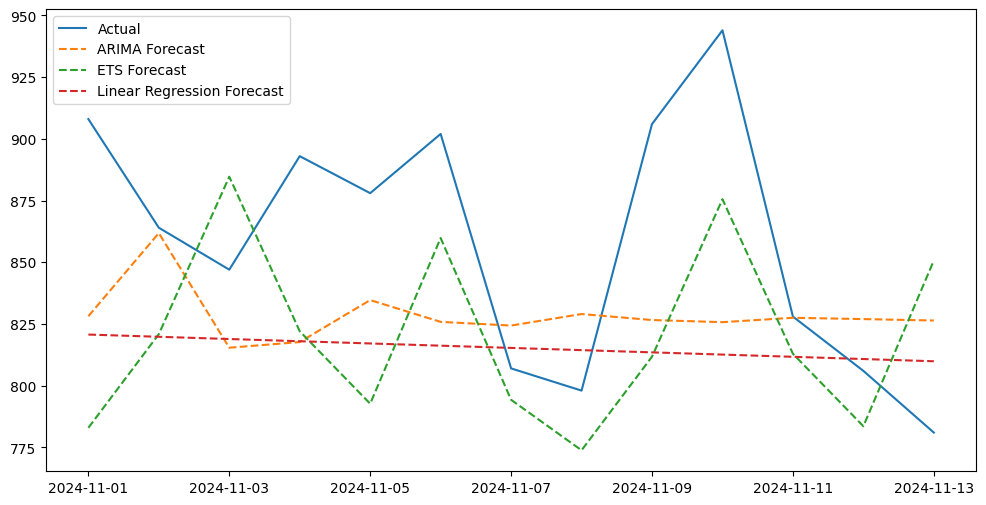

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Load dataset
df = pd.read_csv('D:\gitfolder\Data-DaVinci\Week 4\Assignment\FILES\parkingLot.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date and hour
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

# Filter out data from midnight to 5 AM
mask = (df['hour'] >= 5)
df = df[mask]

# Count vehicles per day
entries_per_day = df[df['camera_id'] == 1].groupby('date').size()

# Handle missing values - Option 1: Forward Fill
entries_per_day_ffill = entries_per_day.fillna(method='ffill')

# Handle missing values - Option 2: Interpolation
entries_per_day_interp = entries_per_day.interpolate()

# Split into training and test sets
train_size = int(len(entries_per_day) * 0.8)
train, test = entries_per_day[:train_size], entries_per_day[train_size:]

# Model 1: ARIMA
arima_model = ARIMA(train, order=(5,1,0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))

# Model 2: Exponential Smoothing
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
ets_result = ets_model.fit()
ets_forecast = ets_result.forecast(steps=len(test))

# Model 3: Linear Regression
days = np.arange(len(train)).reshape(-1, 1)
test_days = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
linreg = LinearRegression().fit(days, train.values.reshape(-1, 1))
linreg_forecast = linreg.predict(test_days).flatten()

# Evaluate Models
mape = lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = lambda y_true, y_pred, naive: np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(y_true - naive))

naive_forecast = train.shift(1).dropna()
naive_forecast = naive_forecast.reindex(test.index, method='ffill')

def evaluate_model(forecast, test, naive):
    return {
        "MASE": mase(test, forecast[:len(test)], naive),
        "MAPE": mape(test, forecast[:len(test)])
    }

print("ARIMA Scores:", evaluate_model(arima_forecast, test, naive_forecast))
print("ETS Scores:", evaluate_model(ets_forecast, test, naive_forecast))
print("Linear Regression Scores:", evaluate_model(linreg_forecast, test, naive_forecast))

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast[:len(test)], label='ARIMA Forecast', linestyle='dashed')
plt.plot(test.index, ets_forecast[:len(test)], label='ETS Forecast', linestyle='dashed')
plt.plot(test.index, linreg_forecast[:len(test)], label='Linear Regression Forecast', linestyle='dashed')
plt.legend()
plt.show()
